# Inputs loading

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns

In [4]:
%cd /Users/fedor.grigoryev/mycode

/Users/fedor.grigoryev/mycode


In [5]:
tcga_directory = '~/projs/tcga/data/cohorts'

expanded_directory = os.path.expanduser(tcga_directory)
cohorts = os.listdir(expanded_directory)
cohorts = [file for file in cohorts if not file.startswith('.')]
cohorts = [coh for coh in cohorts if coh != 'TARGET-NBL'] 

In [6]:
def goi_cohort_profiling(cohorts, goi):
    agggs = []
    
    for coh in tqdm(cohorts): 
        qc = pd.read_csv(f'{expanded_directory}/{coh}/qc.tsv', sep='\t', index_col=0)
        file_annot = pd.read_csv(f'{expanded_directory}/{coh}/file_annotation.tsv', sep='\t', index_col=0)
        tpm = pd.read_csv(f'{expanded_directory}/{coh}/tpm.tsv', sep='\t', index_col=0)
        tpm = np.log2(tpm + 1)
        
        qc_index = qc[qc['qc_passed_flag']].index
        tpm = tpm.loc[:,qc_index]
    
        agg_df = pd.DataFrame(tpm.loc[goi], columns=[goi])
        agg_df['cohort'] = coh
        agg_df['tissue_type'] = file_annot.loc[tpm.loc[goi].index].tissue_type
        agggs.append(agg_df)
        
        aggs_df = pd.concat(agggs)
    return aggs_df

In [183]:
from scipy.stats import ttest_ind

def expression_profile_barplot(aggs_df, goi):
    diagnosis_significance = {}
    
    tumor_df = aggs_df[aggs_df['tissue_type'] == 'Tumor']
    
    cohort_order = tumor_df.groupby('cohort')[goi].median().sort_values().index
    
    plt.figure(figsize=(20, 10))
    
    sns.boxplot(x='cohort', y=goi, hue='tissue_type', data=aggs_df, order=cohort_order)
    
    for cohort in cohort_order:
        tumor_values = aggs_df[(aggs_df['cohort'] == cohort) & (aggs_df['tissue_type'] == 'Tumor')][goi]
        normal_values = aggs_df[(aggs_df['cohort'] == cohort) & (aggs_df['tissue_type'] == 'Normal')][goi]
        p_value = ttest_ind(tumor_values, normal_values)[1]
        diagnosis_significance[cohort] = p_value
        
        if p_value < 0.0001:
            significance = '*\n*\n*'
        elif p_value < 0.001:
            significance = '*\n*'
        elif p_value < 0.01:
            significance = '*'
        else:
            significance = ''  # No significance
            
        if significance:
            plt.plot([cohort_order.tolist().index(cohort) - 0.2, cohort_order.tolist().index(cohort) + 0.2], 
                     [aggs_df[goi].max() + 0.1, aggs_df[goi].max() + 0.1], 
                     lw=1.5, color='black')
            plt.text(cohort_order.tolist().index(cohort), aggs_df[goi].max() - 0.2, significance, ha='center',
                     va='top', fontsize=14)
    
    plt.xticks(rotation=90)
    plt.xlabel('Cohort')
    plt.ylabel(f'{goi} Expression')
    plt.title(f'Boxplot of {goi} Expression by Tissue Type')
    
    # Show plot
    plt.show()

In [7]:
goi = 'MTUS1'
aggs_df = goi_cohort_profiling(cohorts, goi)

  0%|          | 0/64 [00:00<?, ?it/s]

<Axes: xlabel='tissue_type', ylabel='MTUS1'>

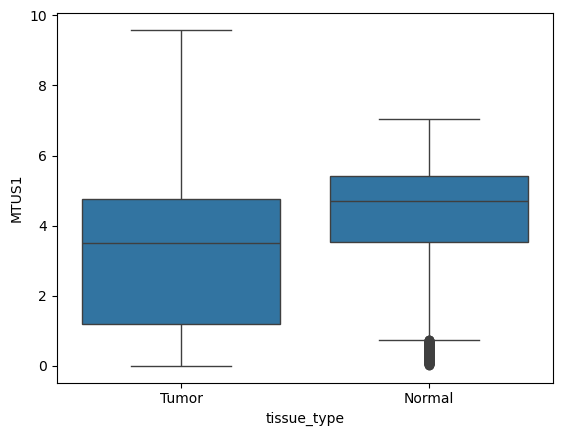

In [15]:
sns.boxplot(x='tissue_type', y='MTUS1', data=aggs_df)

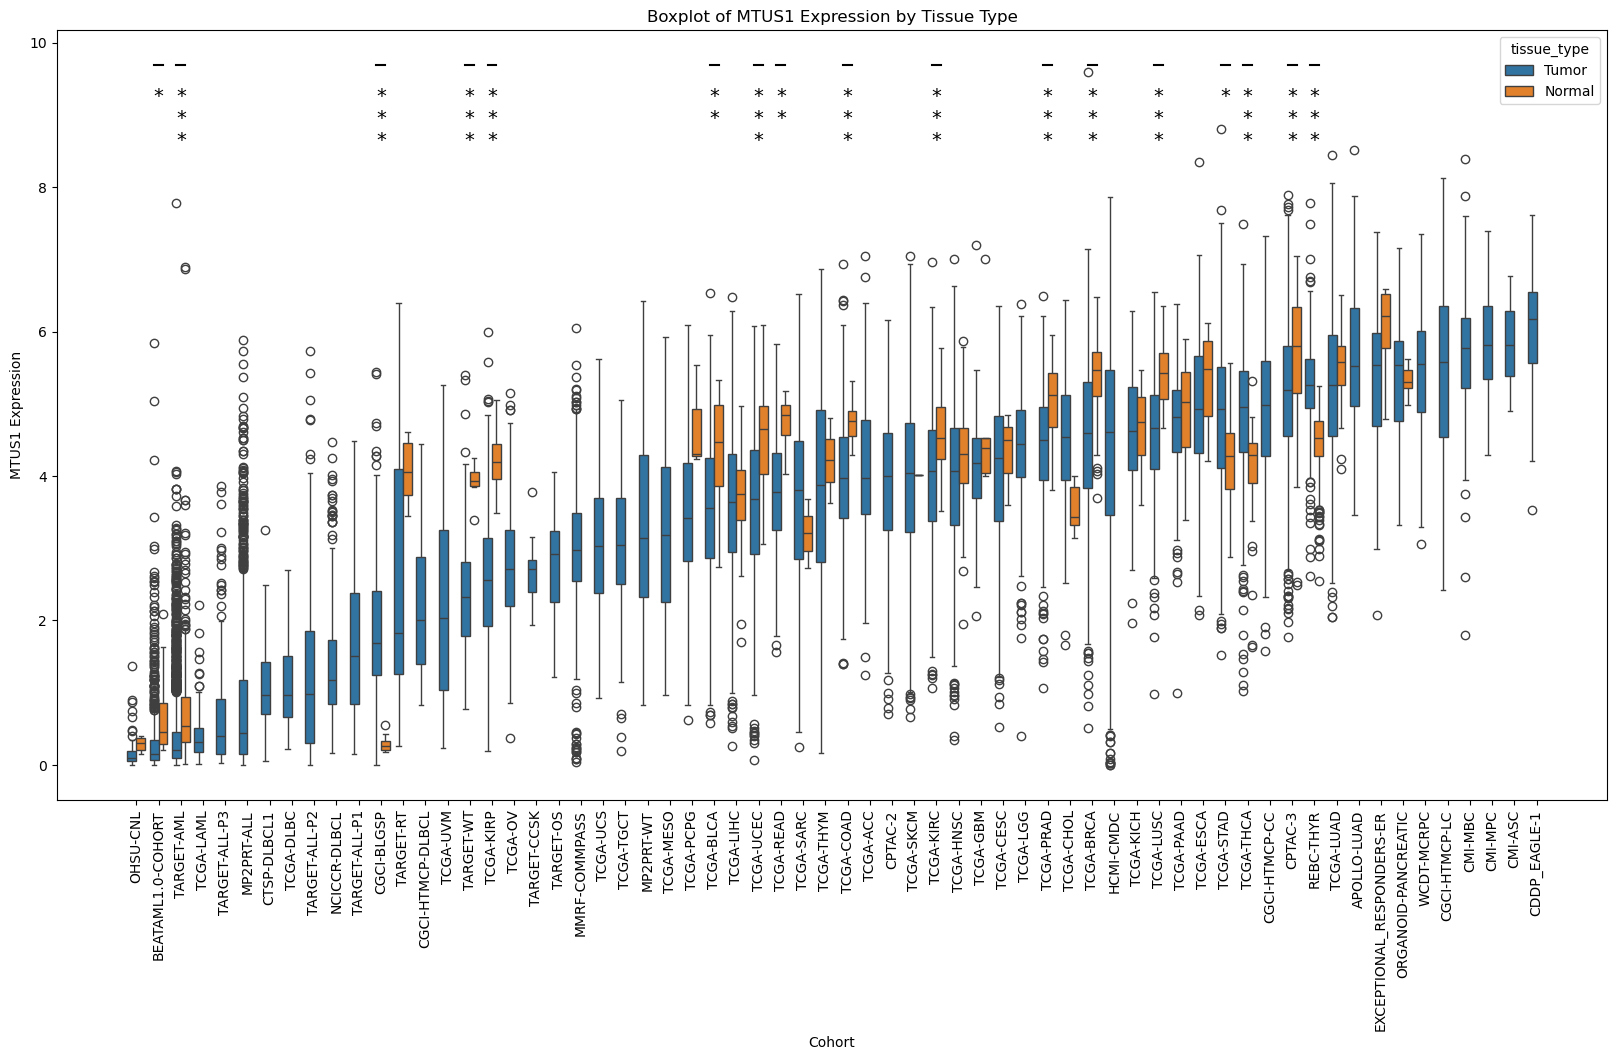

In [184]:
expression_profile_barplot(aggs_df, goi)

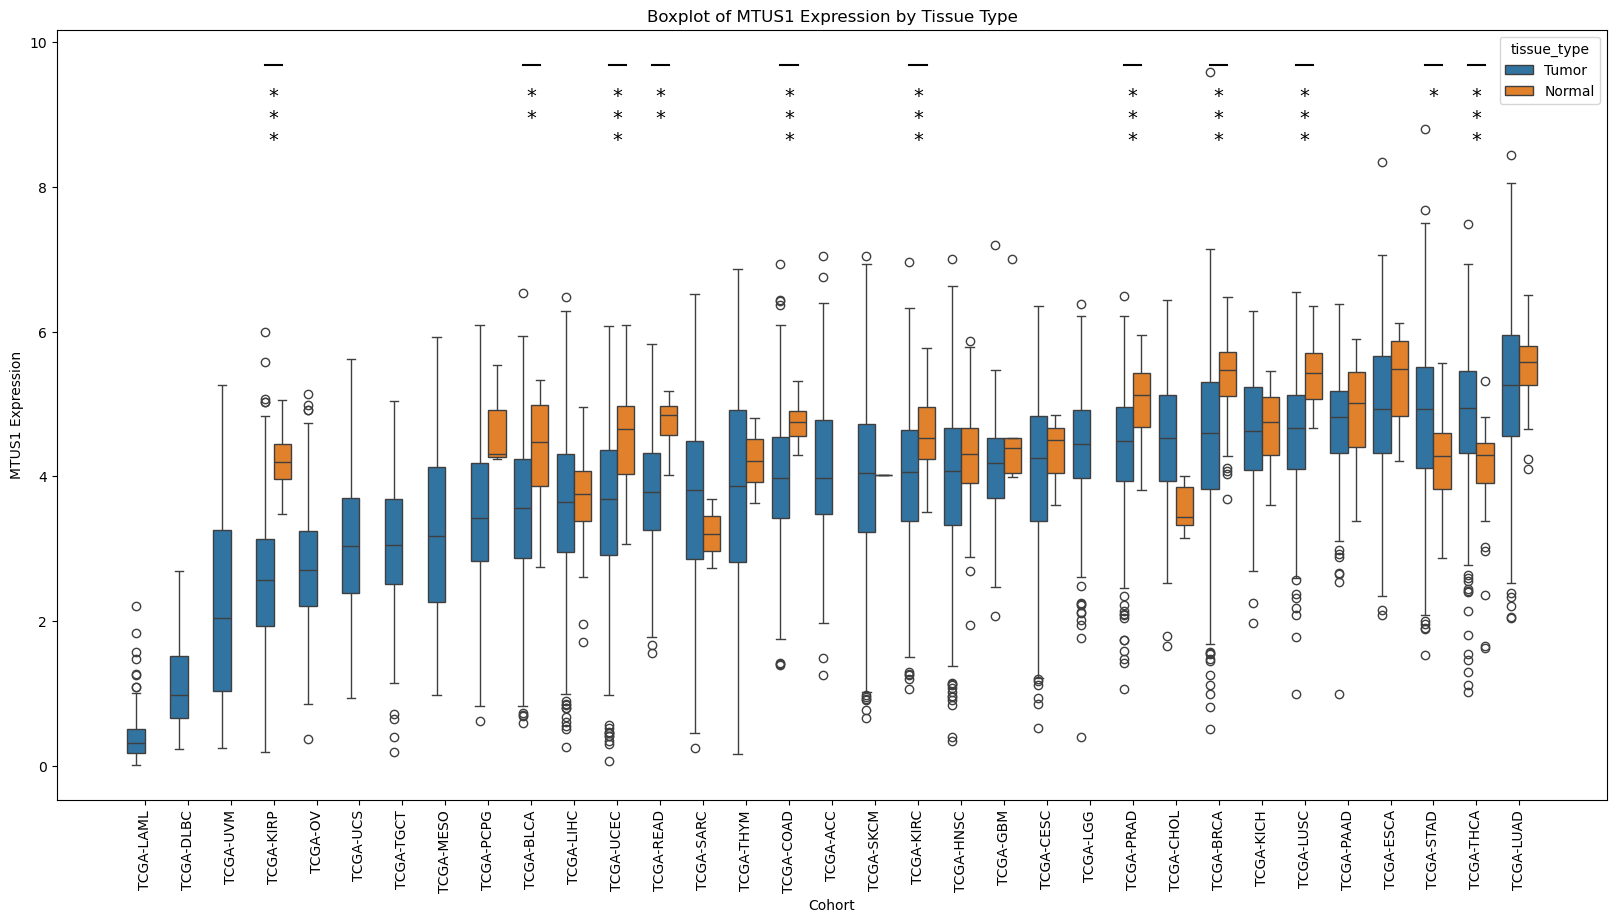

In [185]:
tcga_cohorts = aggs_df['cohort'].apply(lambda x: 'TCGA' in x)

expression_profile_barplot(aggs_df[tcga_cohorts].copy(), goi)

In [186]:
goi = 'HLF'
aggs_df = goi_cohort_profiling(cohorts, goi)

  0%|          | 0/64 [00:00<?, ?it/s]

<Axes: xlabel='tissue_type', ylabel='HLF'>

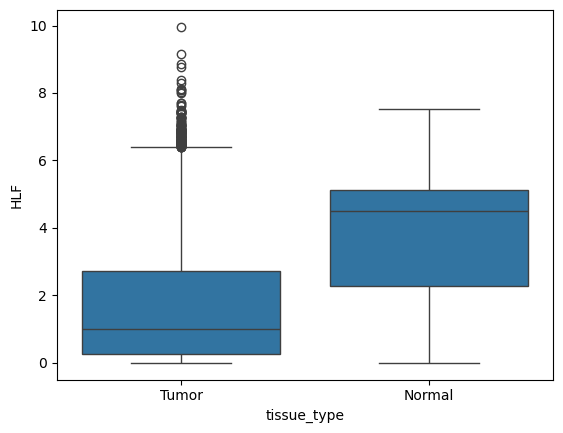

In [187]:
sns.boxplot(x='tissue_type', y='HLF', data=aggs_df)

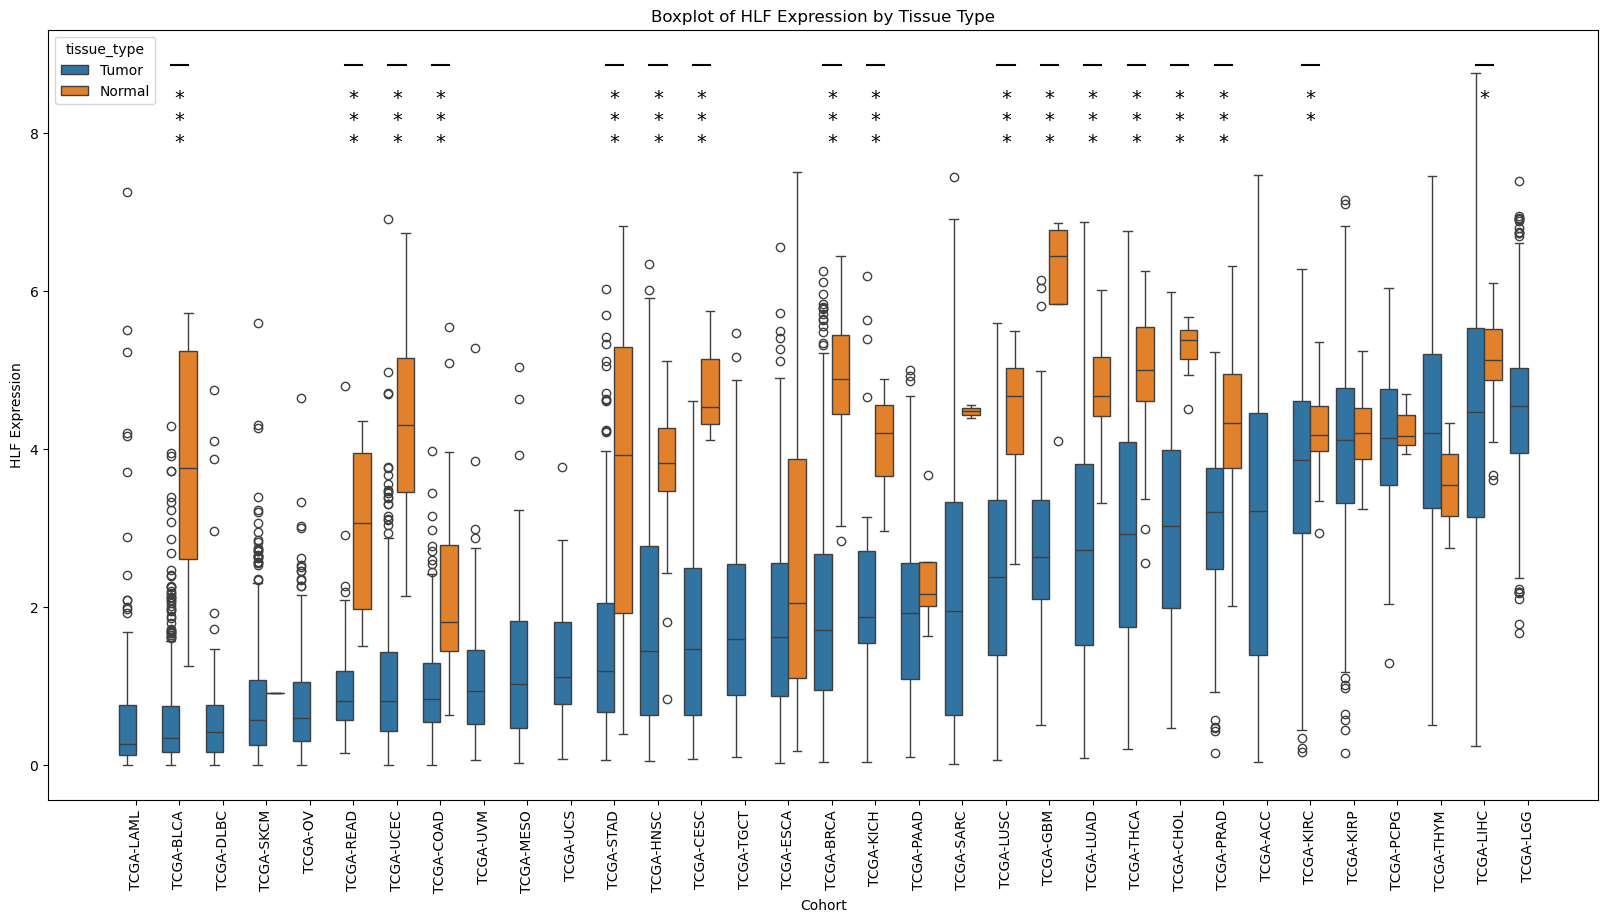

In [188]:
expression_profile_barplot(aggs_df[tcga_cohorts].copy(), goi)

## BRCA analysis

In [142]:
coh = 'TCGA-BRCA'

counts_df = pd.read_csv(f'{expanded_directory}/{coh}/counts.tsv', sep='\t', index_col=0).T
qc = pd.read_csv(f'{expanded_directory}/{coh}/qc.tsv', sep='\t', index_col=0)
ann = pd.read_csv(f'{expanded_directory}/{coh}/clin_annotation.tsv', sep='\t', index_col=0)
ann.replace("'--", np.nan, inplace=True)
file_annot = pd.read_csv(f'{expanded_directory}/{coh}/file_annotation.tsv', sep='\t', index_col=0)
tpm = pd.read_csv(f'{expanded_directory}/{coh}/tpm.tsv', sep='\t', index_col=0).T
tpm = np.log2(tpm + 1)

In [143]:
metadata = file_annot[['tissue_type', 'tumor_descriptor', 'case_id']]
metadata = metadata.loc[counts_df.index]

In [144]:
metadata.shape

(1231, 3)

In [211]:
ls /Users/fedor.grigoryev/projs/tcga/data/biospecimen.cohort.2024-03-09

aliquot.tsv  analyte.tsv  portion.tsv  sample.tsv   slide.tsv


In [230]:
biopsy_annot = pd.read_csv('/Users/fedor.grigoryev/projs/tcga/data/biospecimen.cohort.2024-03-09/sample.tsv', sep='\t')
biopsy_annot.replace("'--", np.nan, inplace=True)
biopsy_annot = biopsy_annot[biopsy_annot.sample_id.isin(file_annot.sample_id)].dropna(axis=1)

In [231]:
biopsy_annot[['specimen_type', 'is_ffpe', 'sample_type', 'tissue_type', 'preservation_method', 'tumor_descriptor']]

,specimen_type,is_ffpe,sample_type,tissue_type,preservation_method,tumor_descriptor
39,Solid Tissue,false,Primary Tumor,Tumor,OCT,Primary
248,Solid Tissue,false,Primary Tumor,Tumor,Unknown,Primary
293,Solid Tissue,false,Primary Tumor,Tumor,OCT,Primary
335,Solid Tissue,false,Primary Tumor,Tumor,OCT,Primary
412,Solid Tissue,false,Primary Tumor,Tumor,OCT,Primary
...,...,...,...,...,...,...
86753,Solid Tissue,false,Primary Tumor,Tumor,OCT,Primary
86821,Solid Tissue,false,Primary Tumor,Tumor,Unknown,Primary
86935,Solid Tissue,false,Primary Tumor,Tumor,Unknown,Primary
87007,Solid Tissue,false,Primary Tumor,Tumor,OCT,Primary


In [233]:
biopsy_annot['specimen_type'].value_counts()

specimen_type
Solid Tissue    1219
Unknown            7
Name: count, dtype: int64

### DE

In [145]:
import os
import pickle as pkl

from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
from pydeseq2.utils import load_example_data

In [146]:
samples_to_keep = qc['qc_passed_flag']
tpm = tpm.loc[samples_to_keep]
counts_df = counts_df.loc[samples_to_keep]
metadata = metadata.loc[samples_to_keep]

genes_to_keep = counts_df.columns[counts_df.sum(axis=0) >= 10]
counts_df = counts_df[genes_to_keep]

In [147]:
import os, sys

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [148]:
def de_pipeline(counts_df, metadata, design_factors, annotate_genes=None):
    inference = DefaultInference(n_cpus=8)
    dds = DeseqDataSet(
        counts=counts_df,
        metadata=metadata,
        design_factors=design_factors,
        refit_cooks=True,
        inference=inference
    )

    dds.deseq2()

    stat_res = DeseqStats(dds, inference=inference)
    stat_res.summary()
    coeff = stat_res.dds.obsm['design_matrix'].columns[-1]
    stat_res.lfc_shrink(coeff=coeff)
    
    significance_dict = {True: 'significant', False: 'not significant'}
    
    stat_res.results_df['significant'] = (stat_res.results_df.padj < 0.01)  & (np.abs(stat_res.results_df.log2FoldChange) > 1.2)
    stat_res.results_df['significant'] = stat_res.results_df['significant'].apply(lambda x: significance_dict[x])
    
    mtus1 = pd.DataFrame(stat_res.results_df.loc['MTUS1']).T
    hlf = pd.DataFrame(stat_res.results_df.loc['HLF']).T
    
    plt.figure(figsize=(10, 6))
    
    sns.scatterplot(data=stat_res.results_df, x='log2FoldChange', y=-np.log10(stat_res.results_df['pvalue'] + 1e-300), hue='significant', alpha=.7)
    sns.scatterplot(data=mtus1, x='log2FoldChange', y=-(mtus1['pvalue'] + 1e-300).apply(lambda x: np.log10(x)), color='red', label='MTUS1')
    sns.scatterplot(data=hlf, x='log2FoldChange', y=-(hlf['pvalue'] + 1e-300).apply(lambda x: np.log10(x)), color='green', label='HLF')

    if annotate_genes is not None:
        offset = 1  # Adjust this value to control the distance of the annotation text from the data point

        for gene in annotate_genes:
            gene_row = stat_res.results_df[stat_res.results_df.index == gene]
            if not gene_row.empty:
                plt.annotate(gene, 
                             (gene_row['log2FoldChange'], -np.log10(gene_row['pvalue'] + 1e-300)), 
                             textcoords="offset points", 
                             xytext=(5, offset),  # Adjust the offset here
                             ha='center', 
                             fontsize=10, 
                             fontweight='bold')

    title = f'{coeff.split('_')[0]}: {" ".join(coeff.split('_')[-3:])}'
    
    plt.xlabel('Log2 Fold Change')
    plt.ylabel('-log10(p-value)')
    plt.title(f'Volcano Plot for {title}')
    plt.legend(title='Significant')
    plt.show()

    return stat_res.results_df

#### Tumor vs Normal

Fitting size factors...
... done in 0.64 seconds.

Fitting dispersions...
... done in 3.71 seconds.

Fitting dispersion trend curve...
... done in 0.22 seconds.

Fitting MAP dispersions...
... done in 3.77 seconds.

Fitting LFCs...
... done in 7.89 seconds.

Replacing 2842 outlier genes.

Fitting dispersions...
... done in 0.58 seconds.

Fitting MAP dispersions...
... done in 0.54 seconds.

Fitting LFCs...
... done in 1.29 seconds.

Running Wald tests...
... done in 5.53 seconds.

Fitting MAP LFCs...
... done in 3.45 seconds.



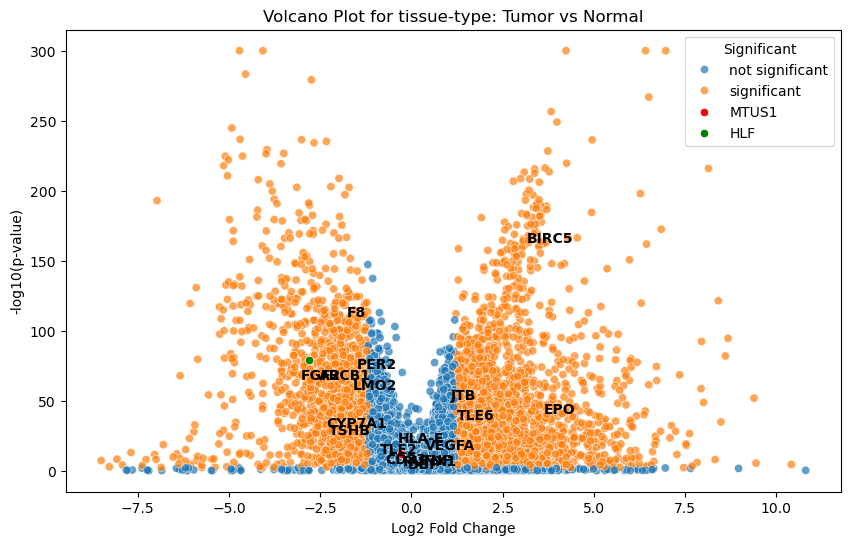

In [149]:
with HiddenPrints():
    tumor_vs_normal_res = de_pipeline(counts_df, metadata, 'tissue_type', annotate_genes=hlf_cistrome.target.values)

#### MTUS1 expression HIGH vs LOW

In [150]:
def label_expression(x, gene_name, tpm):
    q25 = tpm[gene_name].quantile(0.25)
    q75 = tpm[gene_name].quantile(0.75)

    if x > q75:
        return 'HIGH'
    elif x < q25:
        return 'LOW'
    else:
        return 'MED'

metadata['MTUS1_expression'] = tpm['MTUS1'].apply(lambda x: label_expression(x, 'MTUS1', tpm))

In [151]:
metadata['MTUS1_expression'].value_counts()

samples_to_drop = metadata['MTUS1_expression'] == 'MED'
metadata_surv = metadata.loc[~samples_to_drop]

Fitting size factors...
... done in 0.30 seconds.

Fitting dispersions...
... done in 2.60 seconds.

Fitting dispersion trend curve...
... done in 0.23 seconds.

Fitting MAP dispersions...
... done in 2.74 seconds.

Fitting LFCs...
... done in 2.94 seconds.

Replacing 3261 outlier genes.

Fitting dispersions...
... done in 0.48 seconds.

Fitting MAP dispersions...
... done in 0.46 seconds.

Fitting LFCs...
... done in 0.56 seconds.

Running Wald tests...
... done in 1.67 seconds.

Fitting MAP LFCs...
... done in 2.18 seconds.



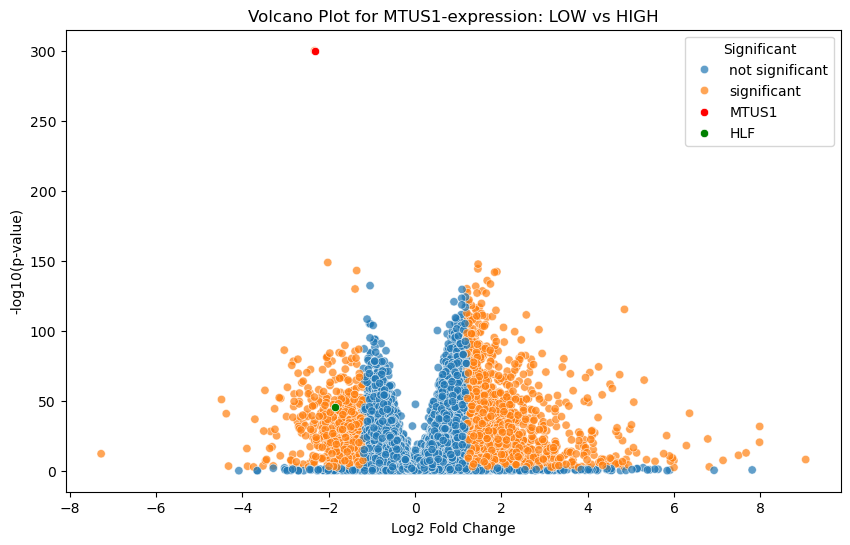

In [152]:
with HiddenPrints():
    mtus1_de_res = de_pipeline(counts_df.loc[metadata_surv.index], metadata_surv, 'MTUS1_expression')

#### Survival

In [ ]:
def quantile_label_trio(x, df, col):
    ql = df[col].quantile(0.3)
    qh = df[col].quantile(0.7)
    
    if x > qh:
        return 'HIGH'
    elif x < ql:
        return 'LOW'
    else:
        return 'MED'



In [156]:
surv_cols = ['case_id', 'days_to_death', 'days_to_last_follow_up', 'vital_status', 'treatment_or_therapy']
ann_surv = ann[surv_cols].copy().set_index('case_id', drop=True).drop_duplicates()


ann_surv['deceased'] = ann_surv['vital_status'].apply(lambda x: False if x == 'Alive' else True)
ann_surv['days_to_death'] = ann_surv['days_to_death'].astype(float).apply(lambda x: np.max([x, 0]))
ann_surv['days_to_last_follow_up'] = ann_surv['days_to_last_follow_up'].astype(float).apply(lambda x: np.max([x, 0]))

ann_surv['OS'] = ann_surv.apply(lambda row: row['days_to_last_follow_up'] if row['vital_status'] == 'Alive' else row['days_to_death'], axis=1).astype(float)
ann_surv['OS_FLAG'] = ann_surv['deceased']
ann_surv = ann_surv.dropna(subset=['OS', 'OS_FLAG'])

ann_surv['Survival'] = ann_surv['OS'].apply(lambda x: quantile_label_trio(x, ann_surv, 'OS'))

case_id
001cef41-ff86-4d3f-a140-a647ac4b10a1     LOW
001cef41-ff86-4d3f-a140-a647ac4b10a1     LOW
0045349c-69d9-4306-a403-c9c1fa836644     LOW
00807dae-9f4a-4fd1-aac2-82eb11bf2afb    HIGH
00807dae-9f4a-4fd1-aac2-82eb11bf2afb    HIGH
                                        ... 
fcef8cb5-fb2c-4bfb-82cd-6b9f3145182c     LOW
fd0b1b8b-1a76-480a-b61c-d176e4e02c6b    HIGH
fe15c48b-116d-461e-9b40-68514730fd18    HIGH
fe7f74b8-20f4-4471-91dc-4cca8c68e5c0     MED
fe7f74b8-20f4-4471-91dc-4cca8c68e5c0     MED
Name: Survival, Length: 1229, dtype: object

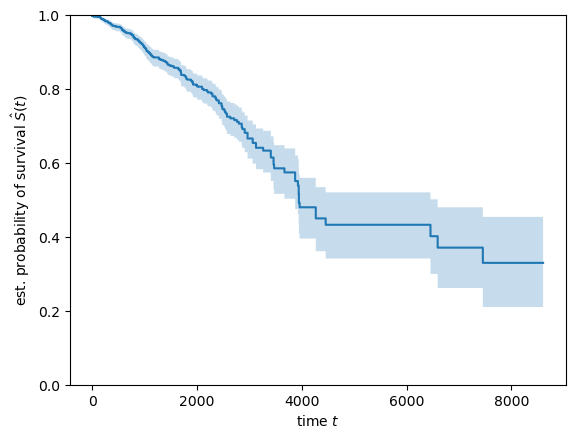

In [157]:
from sksurv.nonparametric import kaplan_meier_estimator

def km_plot(ann_surv):

    time, survival_prob, conf_int = kaplan_meier_estimator(
        ann_surv["OS_FLAG"], ann_surv["OS"], conf_type="log-log"
    )
    
    plt.step(time, survival_prob, where="post")
    plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
    plt.ylim(0, 1)
    plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
    plt.xlabel("time $t$");

km_plot(ann_surv)

In [160]:
matched_metadata_ids = metadata['case_id'].isin(ann_surv.index).copy()
ann_surv_expr = ann_surv.loc[metadata[matched_metadata_ids]['case_id']].copy()

metadata['MTUS1_expression'] = tpm['MTUS1']
metadata['MTUS1_expression_quant'] = tpm['MTUS1'].apply(lambda x: label_expression(x, 'MTUS1', tpm))
ann_surv_expr['MTUS1_expression_quant'] = metadata.groupby('case_id')['MTUS1_expression'].max().apply(lambda x: label_expression(x, 'MTUS1', tpm))

metadata['HLF_expression'] = tpm['HLF']
metadata['HLF_expression_quant'] = tpm['HLF'].apply(lambda x: label_expression(x, 'HLF', tpm))
ann_surv_expr['HLF_expression_quant'] = metadata.groupby('case_id')['HLF_expression'].max().apply(lambda x: label_expression(x, 'HLF', tpm))

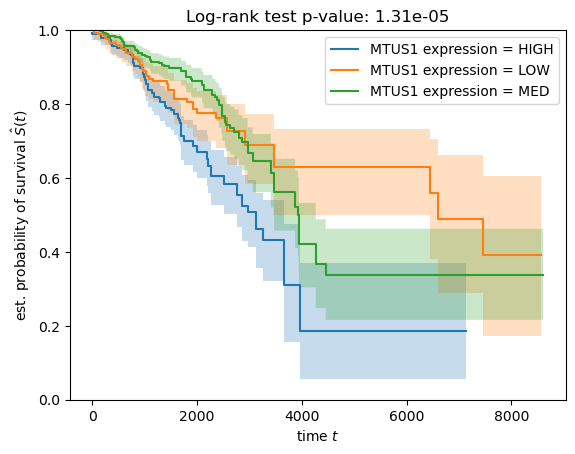

In [161]:
from sksurv.compare import compare_survival

def logrank_km(ann_surv, group_indicator, title):

    y = np.array(
        list(zip(ann_surv["OS_FLAG"], ann_surv["OS"])), 
        dtype=[('status', bool), ('time', float)]
    )
    
    for type in np.unique(group_indicator):
        mask_treat = group_indicator == type
        time_treatment, survival_prob_treatment, conf_int = kaplan_meier_estimator(
            ann_surv["OS_FLAG"][mask_treat],
            ann_surv["OS"][mask_treat],
            conf_type="log-log",
        )
    
        plt.step(time_treatment, survival_prob_treatment, where="post", label=f"{title} = {type}")
        plt.fill_between(time_treatment, conf_int[0], conf_int[1], alpha=0.25, step="post")
    
    chisq, p_value = compare_survival(y, group_indicator, return_stats=False)
    plt.title(f"Log-rank test p-value: {p_value:.2e}", fontsize=12)
    
    plt.ylim(0, 1)
    plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
    plt.xlabel("time $t$")
    plt.legend(loc="best")
    plt.show()

logrank_km(ann_surv_expr, ann_surv_expr['MTUS1_expression_quant'], title='MTUS1 expression')

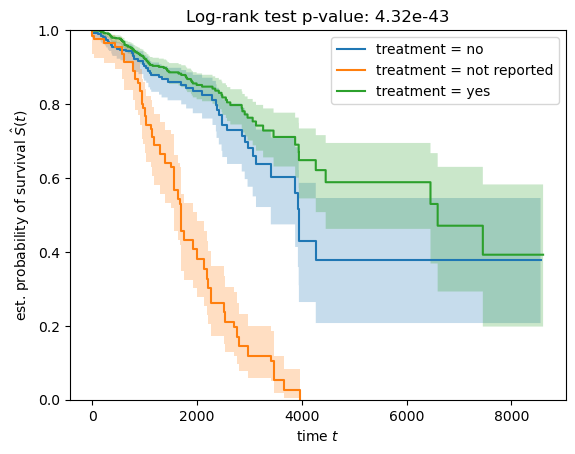

In [162]:
logrank_km(ann_surv_expr, ann_surv_expr['treatment_or_therapy'],  title='treatment')

In [163]:
metadata['case_id'] = file_annot['case_id']

In [165]:
case_id2os = ann_surv['OS'].to_dict()
case_id2os_quant = ann_surv['Survival'].to_dict()
case_id2os_flag = ann_surv['OS_FLAG'].to_dict()
case_id2status = ann_surv['deceased'].to_dict()

In [166]:
metadata['OS'] = metadata['case_id'].map(case_id2os)
metadata['Survival'] = metadata['case_id'].map(case_id2os_quant)
metadata['OS_FLAG'] = metadata['case_id'].map(case_id2os_flag)
metadata['deceased'] = metadata['case_id'].map(case_id2status)

In [168]:
metadata_surv = metadata.dropna(subset=['Survival', 'OS_FLAG'])
metadata_surv = metadata_surv[metadata_surv['Survival'] != 'MED']
metadata_surv['Survival'] = metadata_surv['Survival']

metadata_surv_t = metadata_surv[metadata_surv['tissue_type'] == 'Tumor'].copy()

Fitting size factors...
... done in 0.25 seconds.

Fitting dispersions...
... done in 2.42 seconds.

Fitting dispersion trend curve...
... done in 0.22 seconds.

Fitting MAP dispersions...
... done in 2.57 seconds.

Fitting LFCs...
... done in 2.44 seconds.

Replacing 3318 outlier genes.

Fitting dispersions...
... done in 0.44 seconds.

Fitting MAP dispersions...
... done in 0.43 seconds.

Fitting LFCs...
... done in 0.48 seconds.

Running Wald tests...
... done in 1.26 seconds.

Fitting MAP LFCs...
... done in 2.57 seconds.



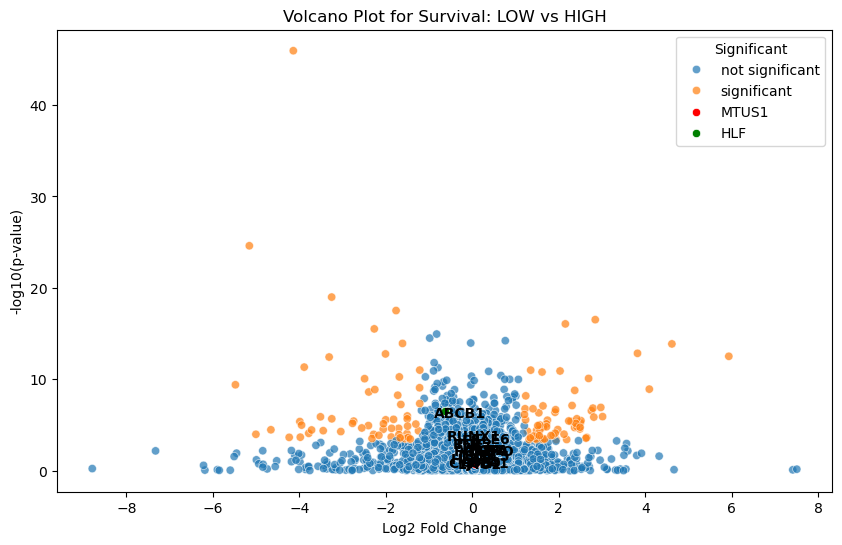

In [170]:
with HiddenPrints():
    surv_de_res = de_pipeline(counts_df.loc[metadata_surv_t.index], metadata_surv_t, 'Survival', annotate_genes=hlf_cistrome.target.values)

### TNBC

To compare mRNA expression with IHC results and eliminate potential false negative and include false positives, we approximated the empirical distributions ESR1, PGR and ERRBB2 mRNA expression from each dataset individually using a two-component Gaussian mixture (R optim package). The following probe sets were used for each of the datasets: GSE41998, GSE25066 and GSE32646; ESR1 (205225_at), PGR (PR208305_at) and ERBB2 (216836_s_at), GSE22226 (GPL4133); ESR1_18336, PGR_2744, and ERBB2_43498, GSE22226 (GPL4133); ESR1_26884, PGR_6923, and ERBB2_37893, GSE22358; ESR1_26884, PGR_15163, and ERBB2_38777. Given the estimated distributions, the posterior probability of negative expression status of ER, PR and HER2 were determined and samples negative for expression of each of these markers identified

<Axes: xlabel='ESR1', ylabel='PGR'>

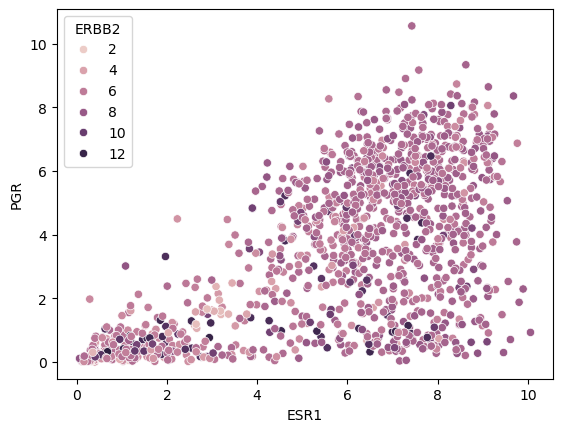

In [171]:
sns.scatterplot(data=tpm, x='ESR1', y='PGR', hue='ERBB2')

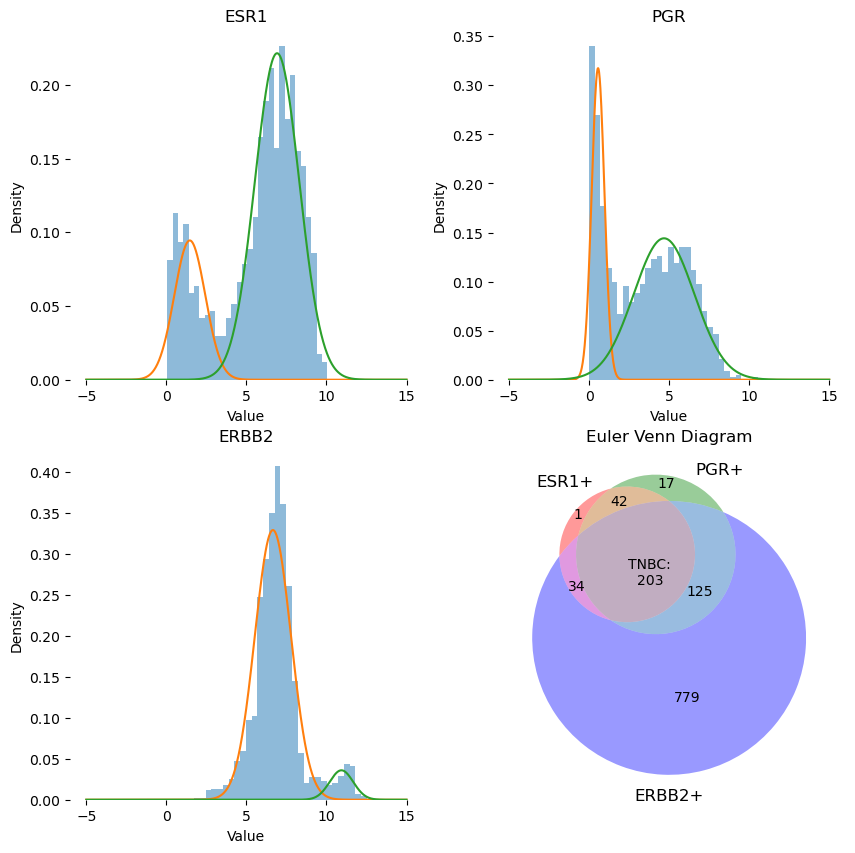

In [172]:
from sklearn.mixture import GaussianMixture
from matplotlib_venn import venn3

results = dict()

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = ax.flatten()

for i, gene in enumerate(['ESR1', 'PGR', 'ERBB2']):
    gmm = GaussianMixture(n_components=2)
    gmm.fit(tpm[gene].values.reshape(-1, 1))

    labels = gmm.predict(tpm[gene].values.reshape(-1, 1))

    subset0_mean = tpm[gene][labels == 0].mean()
    subset1_mean = tpm[gene][labels == 1].mean()

    if subset1_mean > subset0_mean:
        labels_high = labels == 1
    else:
        labels_high = labels == 0
    
    fraction_component1 = np.mean(labels_high == False)
    fraction_component2 = np.mean(labels_high == True)
    results[gene] = labels_high

    means = gmm.means_.flatten()
    covariances = gmm.covariances_.flatten()
    
    sorted_ids = np.argsort(means)
    means = means[sorted_ids]
    covariances = covariances[sorted_ids]

    ax[i].hist(tpm[gene].values.reshape(-1, 1), bins=30, density=True, alpha=0.5)
    x = np.linspace(-5, 15, 1000).reshape(-1, 1)
    ax[i].plot(x, fraction_component1 * np.exp(-(x - means[0])**2 / (2 * covariances[0])) / np.sqrt(2 * np.pi * covariances[0]), label='Component 1')
    ax[i].plot(x, fraction_component2 * np.exp(-(x - means[1])**2 / (2 * covariances[1])) / np.sqrt(2 * np.pi * covariances[1]), label='Component 2')
    ax[i].set_xlabel('Value')
    ax[i].set_ylabel('Density')
    ax[i].set_title(gene)
    ax[i].spines[['top', 'right', 'bottom', 'left']].set_visible(False)

data = results

sets = {
    'ESR1': set(tpm.index[~data['ESR1'].astype(bool)]),
    'PGR': set(tpm.index[~data['PGR'].astype(bool)]),
    'ERBB2': set(tpm.index[~data['ERBB2'].astype(bool)])
}

venn = venn3(subsets=[sets['ESR1'], sets['PGR'], sets['ERBB2']],
             set_labels=('ESR1+', 'PGR+', 'ERBB2+'), ax=ax[3])

tnbc_size = venn.get_label_by_id('111')._text 
venn.get_label_by_id('111').set_text(f'TNBC:\n{tnbc_size}')

ax[3].set_title("Euler Venn Diagram")

plt.show()

In [173]:
tnbc_mask = (~results['ESR1']) & (~results['PGR']) & (~results['ERBB2'])
tnbc_mask.sum()

203

In [174]:
tnbc_ids = tpm[tnbc_mask].index

In [175]:
tumor_mask = file_annot.loc[tpm.index]['tissue_type'] == 'Tumor'
tnbc_tumor_mask = tnbc_mask & tumor_mask
tnbc_tumor_mask.sum()

197

In [194]:
tnbc_subset['HLF'].shape

(197,)

In [195]:
tpm[~tumor_mask]['HLF'].shape

(113,)

In [191]:
tpm[~tumor_mask]['HLF']

4.886768298161443

In [198]:
a = pd.concat([pd.DataFrame(tnbc_subset['HLF']), tpm[~tumor_mask]['HLF']], axis=0)
a['Source'] = ['TNBC'] * len(tnbc_subset) + ['Normal'] * sum(~tumor_mask)
a

,HLF,Source
0d140db1-dc0d-431d-b389-846d05bbb827,2.176801,TNBC
d141392c-757b-44f5-b531-0bcc136d8b17,3.501923,TNBC
7860a938-e43a-4c3a-83b4-6578cea95df8,0.899872,TNBC
4b8ef410-8612-4c64-839f-47770deba446,0.983386,TNBC
0ed77a2e-a2c9-4557-8ba3-2c8bade9b792,2.638792,TNBC
...,...,...
cbfb8ffe-ae83-4a16-aaa6-f21ea893cb8d,3.020253,Normal
392edd04-fdec-4eb7-ba2e-cef02519c219,4.713899,Normal
b70b68a1-28c4-4ed3-a04c-b622e583f10b,4.020822,Normal
9e5ecae5-faf0-41a2-a795-d1b4db79486a,4.680623,Normal


<Axes: xlabel='Source', ylabel='HLF'>

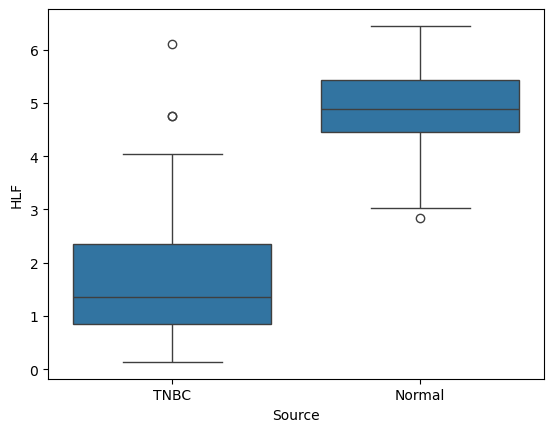

In [201]:
sns.boxplot(x='Source', y='HLF', data=a)

In [178]:
tnbc_subset_w_norm = tpm[tnbc_mask+(~tumor_mask)].copy()
tnbc_subset = tpm[tnbc_tumor_mask].copy()

metadata_tnbc = metadata.loc[tnbc_subset.index]
metadata_tnbc_w_norm = metadata.loc[tnbc_subset_w_norm.index]

In [179]:
surv_cols = ['case_id', 'days_to_death', 'days_to_last_follow_up', 'vital_status', 'treatment_or_therapy']
ann_surv = ann[surv_cols].copy().set_index('case_id', drop=True)

ann_surv['deceased'] = ann_surv['vital_status'].apply(lambda x: False if x == 'Alive' else True)
ann_surv['days_to_death'] = ann_surv['days_to_death'].astype(float).apply(lambda x: np.max([x, 0]))
ann_surv['days_to_last_follow_up'] = ann_surv['days_to_last_follow_up'].astype(float).apply(lambda x: np.max([x, 0]))

ann_surv['OS'] = ann_surv.apply(lambda row: row['days_to_last_follow_up'] if row['vital_status'] == 'Alive' else row['days_to_death'], axis=1).astype(float)
ann_surv['OS_FLAG'] = ann_surv['deceased']

In [180]:
def quantile_label_trio(x, df, col):
    ql = df[col].quantile(0.3)
    qh = df[col].quantile(0.7)
    
    if x > qh:
        return 'HIGH'
    elif x < ql:
        return 'LOW'
    else:
        return 'MED'

def quantile_label_duo(x, df, col):
    qm = df[col].quantile(0.5)
    
    if x > qm:
        return 'HIGH'
    else:
        return 'LOW'

metadata_tnbc['Survival'] = metadata_tnbc['OS'].apply(lambda x: quantile_label_duo(x, metadata_tnbc, 'OS'))
metadata_tnbc_t = metadata_tnbc[metadata_tnbc['tissue_type'] == 'Tumor'].copy()

Fitting size factors...
... done in 0.09 seconds.

Fitting dispersions...
... done in 2.02 seconds.

Fitting dispersion trend curve...
... done in 0.22 seconds.

Fitting MAP dispersions...
... done in 1.91 seconds.

Fitting LFCs...
... done in 1.01 seconds.

Replacing 3246 outlier genes.

Fitting dispersions...
... done in 0.31 seconds.

Fitting MAP dispersions...
... done in 0.30 seconds.

Fitting LFCs...
... done in 0.23 seconds.

Running Wald tests...
... done in 0.53 seconds.

Fitting MAP LFCs...
... done in 1.83 seconds.



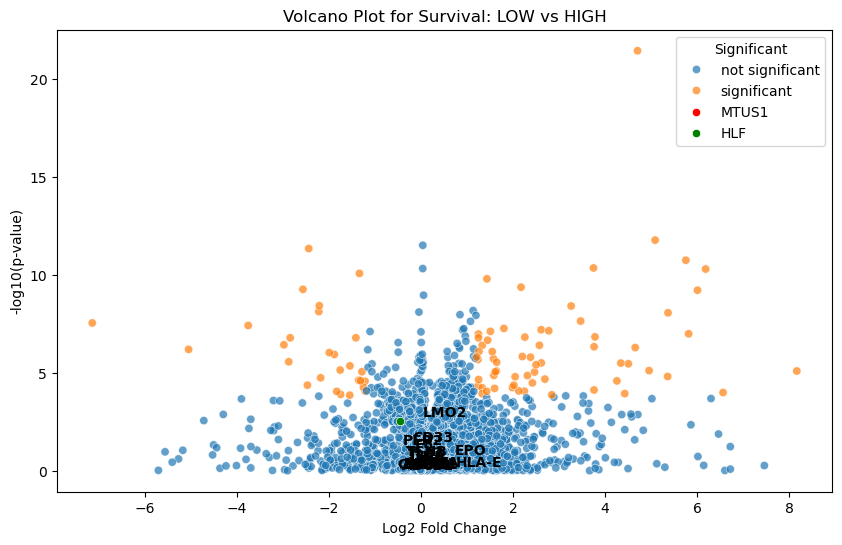

In [181]:
with HiddenPrints():
    surv_de_res = de_pipeline(counts_df.loc[metadata_tnbc_t.index], metadata_tnbc_t, 'Survival', annotate_genes=hlf_cistrome.target.values)

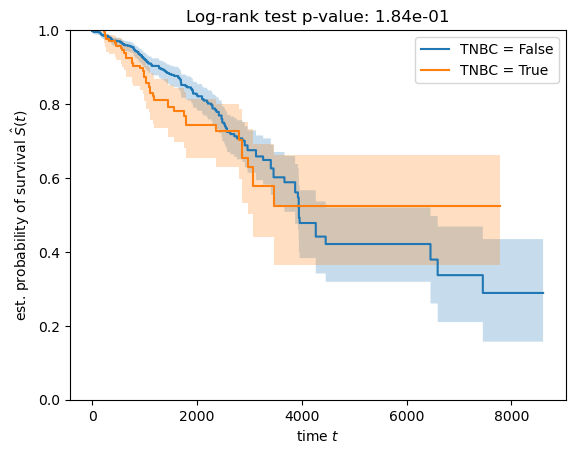

In [182]:
logrank_km(ann_surv_expr.drop_duplicates(), ann_surv_expr.drop_duplicates().index.isin(file_annot.loc[tnbc_ids].case_id), title='TNBC')

## Transcription factor exploration

In [49]:
import decoupler as dc

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [50]:
net = dc.get_collectri(organism='human', split_complexes=False)
net

,source,target,weight,PMID
0,MYC,TERT,1,10022128;10491298;10606235;10637317;10723141;1...
1,SPI1,BGLAP,1,10022617
2,SMAD3,JUN,1,10022869;12374795
3,SMAD4,JUN,1,10022869;12374795
4,STAT5A,IL2,1,10022878;11435608;17182565;17911616;22854263;2...
...,...,...,...,...
43173,NFKB,hsa-miR-143-3p,1,19472311
43174,AP1,hsa-miR-206,1,19721712
43175,NFKB,hsa-miR-21-5p,1,20813833;22387281
43176,NFKB,hsa-miR-224-5p,1,23474441;23988648


In [51]:
(net['source'] == 'HLF').value_counts()

source
False    43160
True        18
Name: count, dtype: int64

In [52]:
hlf_cistrome = net[net['source'] == 'HLF']
hlf_cistrome

,source,target,weight,PMID
94,HLF,JTB,1,10073576
95,HLF,F8,1,10073576
273,HLF,EPO,1,10202154;9113979
4229,HLF,HLA-E,1,11952136
9829,HLF,ABCB1,1,16206189;18773899
16695,HLF,FGF2,1,19526458
17357,HLF,BIRC5,1,19887369
17832,HLF,CD33,1,20147975
18483,HLF,LMO2,1,12609830;20519628
19460,HLF,TSHB,1,21129973


In [252]:
hlf_targeted = ['JTB', 'F8', 'EPO', 'HLA-E', 'ABCB1', 'FGF2', 'BIRC5', 'CD33',
       'LMO2', 'TSHB', 'PER2', 'TNF', 'CYP7A1', 'VEGFA', 'DBP', 'TLE6', 'TLE2']

In [44]:
net[net['target'] == 'HLF']

,source,target,weight,PMID
28019,BMAL1,HLF,1,9704006


In [46]:
hlf_cistrome.target.values

array(['JTB', 'F8', 'EPO', 'HLA-E', 'ABCB1', 'FGF2', 'BIRC5', 'CD33',
       'LMO2', 'TSHB', 'PER2', 'TNF', 'CYP7A1', 'VEGFA', 'DBP', 'RUNX1',
       'TLE6', 'TLE2'], dtype=object)

In [243]:
import sys; print(sys.version)
import platform; print(platform.python_implementation()); print(platform.platform())
import gseapy; print(gseapy.__version__)

3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:35:20) [Clang 16.0.6 ]
CPython
macOS-14.4.1-arm64-arm-64bit
1.1.2


In [253]:
genesets = {'hlf_cistrome': hlf_targeted}

In [254]:
result = gseapy.gsea(data=tpm.T, gene_sets=genesets, cls=metadata['tissue_type'])

In [255]:
print(result.res2d)

   Name          Term        ES       NES NOM p-val FDR q-val FWER p-val  \
0  gsea  hlf_cistrome -0.557751 -1.642767   0.01378   0.01378    0.01378   

  Tag %  Gene %                                      Lead_genes  
0  9/17  11.37%  FGF2;F8;LMO2;ABCB1;CYP7A1;HLA-E;PER2;TSHB;TLE2  


In [256]:
result.res2d.head(5)

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,gsea,hlf_cistrome,-0.557751,-1.642767,0.01378,0.01378,0.01378,9/17,11.37%,FGF2;F8;LMO2;ABCB1;CYP7A1;HLA-E;PER2;TSHB;TLE2


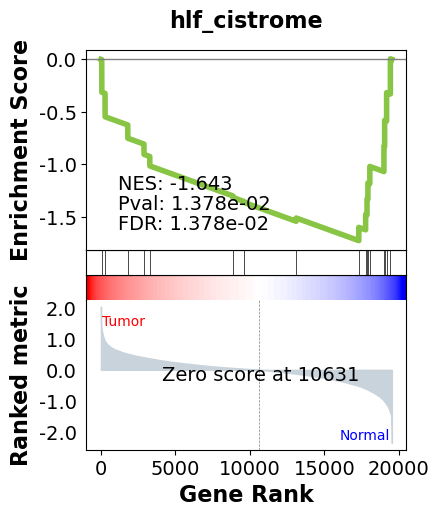

In [257]:
terms = result.res2d.Term
axs = result.plot(terms=terms[0]) # v1.0.5
# to make more control on the plot, use
# from gseapy import gseaplot
# gseaplot(rank_metric=pre_res.ranking, term=terms[0], ofname='your.plot.pdf', **pre_res.results[terms[0]])

In [258]:
tnbc_dict = {True: 'TNBC', False: 'Non TNBC'}
tnbc_names = np.vectorize(tnbc_dict.get)(tnbc_mask)
tnbc_names

array(['TNBC', 'Non TNBC', 'Non TNBC', ..., 'TNBC', 'Non TNBC',
       'Non TNBC'], dtype='<U8')

In [259]:
result = gseapy.gsea(data=tpm.T, gene_sets=genesets, cls=tnbc_names)

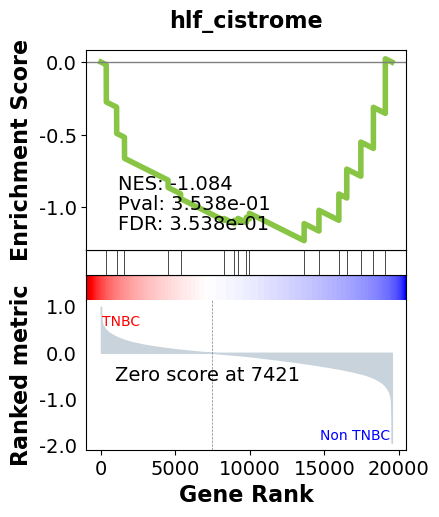

In [260]:
terms = result.res2d.Term
axs = result.plot(terms=terms[0]) # v1.0.5

In [262]:
 tumor_mask = metadata['tissue_type'] == 'Tumor'

In [263]:
tnbc_names[tumor_mask]

array(['TNBC', 'Non TNBC', 'Non TNBC', ..., 'TNBC', 'Non TNBC',
       'Non TNBC'], dtype='<U8')

In [264]:
result = gseapy.gsea(data=tpm[tumor_mask].T, gene_sets=genesets, cls=tnbc_names[tumor_mask])

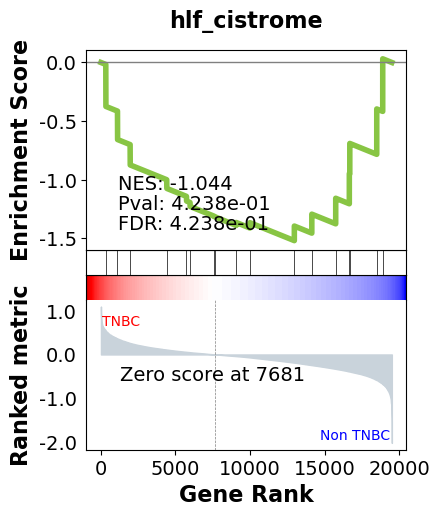

In [265]:
terms = result.res2d.Term
axs = result.plot(terms=terms[0])

In [266]:
metadata.loc[tnbc_mask]['tissue_type'].value_counts()

tissue_type
Tumor     197
Normal      6
Name: count, dtype: int64

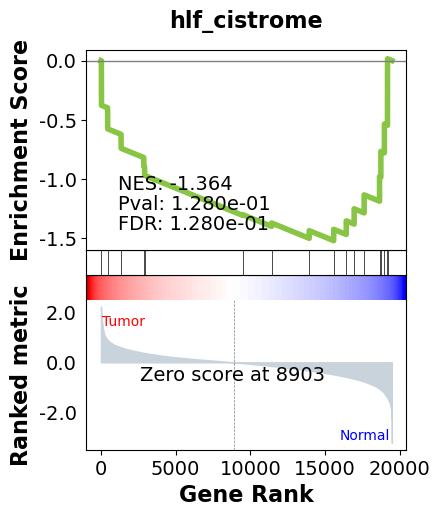

In [267]:
result = gseapy.gsea(data=tpm.T[tnbc_subset_w_norm.index], gene_sets=genesets, cls=metadata.loc[tnbc_subset_w_norm.index]['tissue_type'])
terms = result.res2d.Term
axs = result.plot(terms=terms[0])

In [268]:
ssgsea_results = gseapy.ssgsea(data=tpm.T,
                            gene_sets=genesets,
                            scale=True)

In [270]:
ssgsea_results.res2d

,Name,Term,ES,NES
0,a7091211-3bf5-4d3b-8625-57281bc0cd56,hlf_cistrome,2536.430489,0.919342
1,90617797-d2c7-4c49-bffe-b2bea96a7cf1,hlf_cistrome,2533.20393,0.918172
2,9dc09c86-c728-4bd9-b2b6-2d9962dad662,hlf_cistrome,2411.232844,0.873963
3,131d96e3-0799-4956-a752-dc244a05c493,hlf_cistrome,2359.227388,0.855114
4,2081a155-9d2d-41f6-b243-68a12e9b342a,hlf_cistrome,2318.292807,0.840277
...,...,...,...,...
1217,fc0e74d2-ab94-48b1-8e31-808bde7a3fe6,hlf_cistrome,60.664342,0.021988
1218,ff570f9a-a252-496d-a452-344063851a7b,hlf_cistrome,40.658113,0.014737
1219,4dc3285f-fd32-4a3e-ad59-28597ab5323a,hlf_cistrome,35.541212,0.012882
1220,d923e06d-c747-419d-bd40-b05eb3e13edb,hlf_cistrome,-17.375372,-0.006298


In [272]:
ssgsea_res = ssgsea_results.res2d.sort_values(by='NES').set_index('Name')
ssgsea_res['NES']

,Term,ES,NES
Name,,,
6e112ec6-1791-4764-8a62-7ad4dfea2d3b,hlf_cistrome,-222.532897,-0.080658
148fc636-0b7b-4f10-b513-45edcf71a79e,hlf_cistrome,-172.315018,-0.062456
7002e8cb-0d64-4d4b-a483-bf6dec3c2abb,hlf_cistrome,-154.413763,-0.055968
c38adc46-f0f2-4c71-91b6-da2159dcb190,hlf_cistrome,-107.188788,-0.038851
d923e06d-c747-419d-bd40-b05eb3e13edb,hlf_cistrome,-17.375372,-0.006298
...,...,...,...
2081a155-9d2d-41f6-b243-68a12e9b342a,hlf_cistrome,2318.292807,0.840277
131d96e3-0799-4956-a752-dc244a05c493,hlf_cistrome,2359.227388,0.855114
9dc09c86-c728-4bd9-b2b6-2d9962dad662,hlf_cistrome,2411.232844,0.873963


In [313]:
spearmanr(ssgsea_res.loc[tpm.index]['NES'], tpm['HLF'])

SignificanceResult(statistic=0.14226260536433516, pvalue=5.931980324636251e-07)

In [310]:
spearmanr(ssgsea_res.loc[tpm.index]['NES'], tpm['RUNX1'])

SignificanceResult(statistic=-0.3096345993825161, pvalue=1.459884724767409e-28)

In [311]:
spearmanr(tpm['HLF'], tpm['RUNX1'])

SignificanceResult(statistic=0.25618342513794357, pvalue=9.156617265550631e-20)

<Axes: xlabel='HLF', ylabel='RUNX1'>

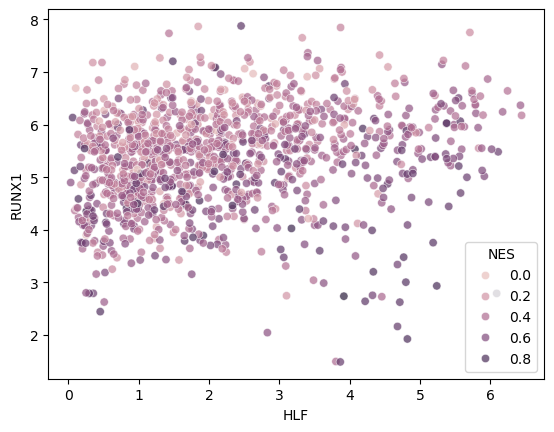

In [315]:
sns.scatterplot(x=tpm['HLF'], y=tpm['RUNX1'], hue=ssgsea_res.loc[tpm.index]['NES'], alpha=.7)

In [ ]:
ssgsea_res['NES']

In [319]:
ann_surv.index.map

,days_to_death,days_to_last_follow_up,vital_status,treatment_or_therapy,deceased,OS,OS_FLAG
case_id,,,,,,,
001cef41-ff86-4d3f-a140-a647ac4b10a1,NaN,337.0,Alive,no,False,337.0,False
001cef41-ff86-4d3f-a140-a647ac4b10a1,NaN,337.0,Alive,yes,False,337.0,False
0045349c-69d9-4306-a403-c9c1fa836644,NaN,259.0,Alive,not reported,False,259.0,False
0045349c-69d9-4306-a403-c9c1fa836644,NaN,259.0,Alive,not reported,False,259.0,False
00807dae-9f4a-4fd1-aac2-82eb11bf2afb,NaN,3102.0,Alive,no,False,3102.0,False
...,...,...,...,...,...,...,...
fe7f74b8-20f4-4471-91dc-4cca8c68e5c0,NaN,1532.0,Alive,no,False,1532.0,False
fec0da58-1047-44d2-b6d1-c18cceed43dc,NaN,375.0,Alive,yes,False,375.0,False
fec0da58-1047-44d2-b6d1-c18cceed43dc,NaN,375.0,Alive,yes,False,375.0,False


case_id
001cef41-ff86-4d3f-a140-a647ac4b10a1    0.460194
0045349c-69d9-4306-a403-c9c1fa836644    0.203349
00807dae-9f4a-4fd1-aac2-82eb11bf2afb    0.424905
00a2d166-78c9-4687-a195-3d6315c27574    0.670375
00b11ca8-8540-4a3d-b602-ec754b00230b    0.402338
                                          ...   
fe15c48b-116d-461e-9b40-68514730fd18    0.491955
fe2cd610-aa52-4789-ac62-7683281bb22f    0.592677
fe7f74b8-20f4-4471-91dc-4cca8c68e5c0    0.218951
fec0da58-1047-44d2-b6d1-c18cceed43dc    0.419375
ff0f875f-113a-4c0f-8c0a-4259cd496e6d     0.50997
Name: NES, Length: 1088, dtype: object

In [ ]:
metadata['MTUS1_expression'] = tpm['MTUS1'].apply(lambda x: label_expression(x, 'MTUS1', tpm))

In [323]:
file2case = file_annot['case_id']
len(set(file2case.values)), len(set(file2case.index))

(1095, 1231)

In [297]:
tnbc_subset.index.map(file2case)

Index(['408cb583-6dc3-4698-8bd2-e284042bd5ef',
       '49717f75-0f2d-4e1c-9a12-f1cd7877b80a',
       '4ac693e9-10f3-46b3-9d46-df3af7b0d259',
       '8c09f413-e938-4f2e-a414-84f0e7fcfe41',
       '1c3610f7-e0aa-48d7-9a27-0dbaf6e244f9',
       '8785012f-f73e-4d68-87cf-1d804af32782',
       'ac075bc0-1b59-4557-beea-541694faee03',
       'ac68d219-5670-4ddd-8df6-8aa7ad59e5c7',
       'b2ecbc0f-2c30-4200-8d5e-7b95424bcadb',
       'b343bfe0-7c23-4c6a-8c84-9ee39db2ecda',
       ...
       'a6e11b30-3ae8-4dd1-b04c-a730c6a79746',
       '75b3fe55-1a63-426e-867e-2ef52f54778d',
       '58090433-d8d1-4499-a235-810c3e9d5b74',
       '91a2f2af-e4b1-4a0b-ab20-6a36ce63c533',
       'cf9db1af-17f0-490e-8139-142bd704763a',
       '95c53f69-0f05-4348-822a-571f3d757001',
       '96312510-c126-485d-8109-ed81844a1dc3',
       '35bd694d-1dd2-466f-ab27-03320614b40e',
       '36fe6152-f61e-4948-9ccc-23ac01a9d77d',
       '60df7543-6da5-4c75-943b-5800c1e08234'],
      dtype='object', length=197)

In [334]:
tnbc_cases = tnbc_subset.index.map(file2case)
ann_surv_tnbc = ann_surv.loc[tnbc_cases]

ssgsea_res['case_id'] = ssgsea_res.index.map(file2case)
ssgsea_res['HLF'] = tpm['HLF']

ann_surv_tnbc['NES'] = ssgsea_res.groupby('case_id')['NES'].mean()
ann_surv_tnbc['HLF'] = ssgsea_res.groupby('case_id')['HLF'].mean()


In [335]:
ann_surv_tnbc['NES_quant'] = ann_surv_tnbc['NES'].apply(lambda x: quantile_label_trio(x, ann_surv_tnbc, 'NES'))
ann_surv_tnbc['HLF'] = ann_surv_tnbc['HLF'].apply(lambda x: quantile_label_trio(x, ann_surv_tnbc, 'HLF'))

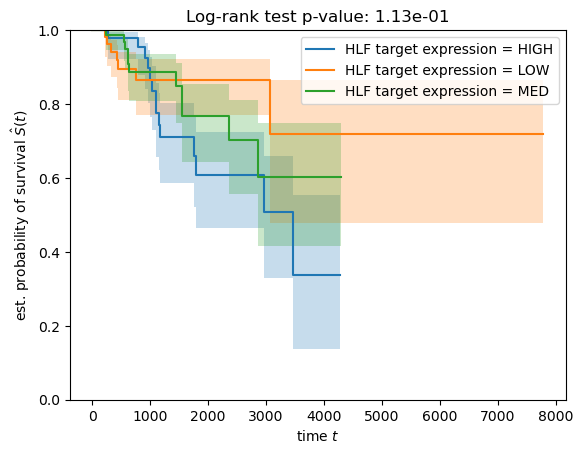

In [336]:
logrank_km(ann_surv_tnbc, ann_surv_tnbc['HLF'], title='HLF target expression')

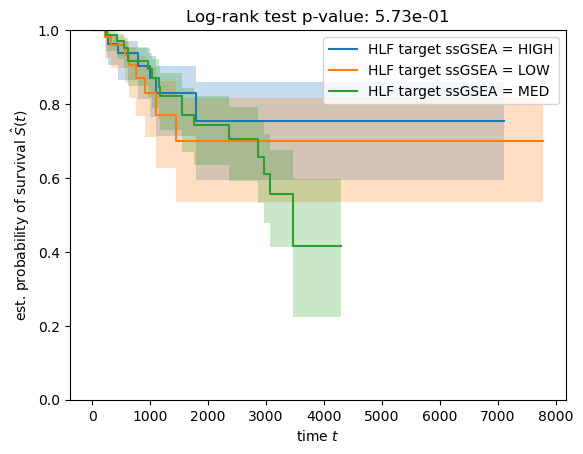

In [332]:
logrank_km(ann_surv_tnbc, ann_surv_tnbc['NES_quant'], title='HLF target ssGSEA')

In [ ]:
logrank_km(ann_surv_expr, ann_surv_expr['MTUS1_expression_quant'], title='MTUS1 expression')

In [ ]:
metadata['MTUS1_expression'] = tpm['MTUS1'].apply(lambda x: label_expression(x, 'MTUS1', tpm))

In [283]:
metadata['ssgsea_NES'] = ssgsea_res.loc[metadata.index]['NES'].astype('float')

(-0.08956375310041807, 0.20954496855818255)

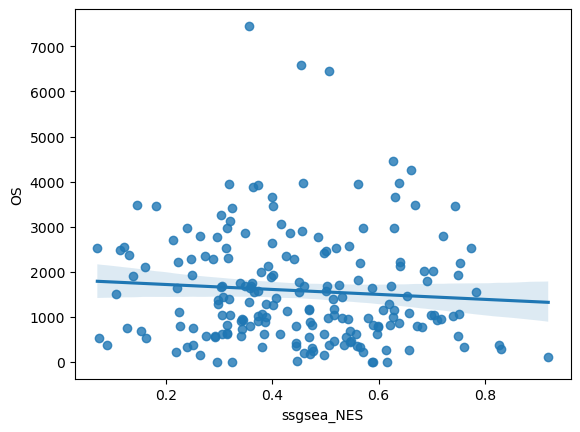

In [290]:
from scipy.stats import spearmanr

r, p = spearmanr(metadata[metadata.deceased == True].dropna()['ssgsea_NES'], metadata[metadata.deceased == True].dropna()['OS'])
sns.regplot(x='ssgsea_NES', y='OS', data=metadata[metadata.deceased == True].dropna())
r, p

In [331]:
from scipy.spatial import distance
from scipy.cluster import hierarchy

labels = ["low_immune" if i == 1 else "immune" for i in hierarchy.fcluster(
  hierarchy.linkage(distance.pdist(ssGSEA.T), method="average"),
  t=2,
  criterion="maxclust"
)]